In [37]:
import pandas as pd
import geopandas
from aws_helpers import execute_athena_query
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline

yesterday = datetime.today() - timedelta(days = 1)

results_url = execute_athena_query(f"select site_id, site_name, lat, lon, min(temperature) as temperature from weather where year='{yesterday.year}' and month='{yesterday.month}' and day='{yesterday.day}' group by site_id, site_name, lat, lon")
df = pd.read_csv(results_url)

df

Executing: select site_id, site_name, lat, lon, min(temperature) as temperature from weather where year='2022' and month='1' and day='3' group by site_id, site_name, lat, lon
Wait count 0/30
Query succeeded


,site_id,site_name,lat,lon,temperature
0,3002,BALTASOUND,60.7490,-0.8540,0.4
1,3068,LOSSIEMOUTH,57.7120,-3.3220,1.5
2,3214,WALNEY ISLAND,54.1250,-3.2570,3.7
3,3230,REDESDALE CAMP,55.2850,-2.2790,-1.0
4,3281,FYLINGDALES,54.3620,-0.6730,1.2
...,...,...,...,...,...
133,3507,SENNYBRIDGE,52.0630,-3.6140,4.8
134,3520,SHOBDON SAWS,52.2420,-2.8850,6.1
135,3544,CHURCH LAWFORD,52.3580,-1.3300,6.5
136,3680,ROTHAMSTED,51.8067,-0.3602,6.8


# Raw Scatter plot

Note that the coordinates will look a bit weird, because the earth is round ;)

<AxesSubplot:xlabel='lon', ylabel='lat'>

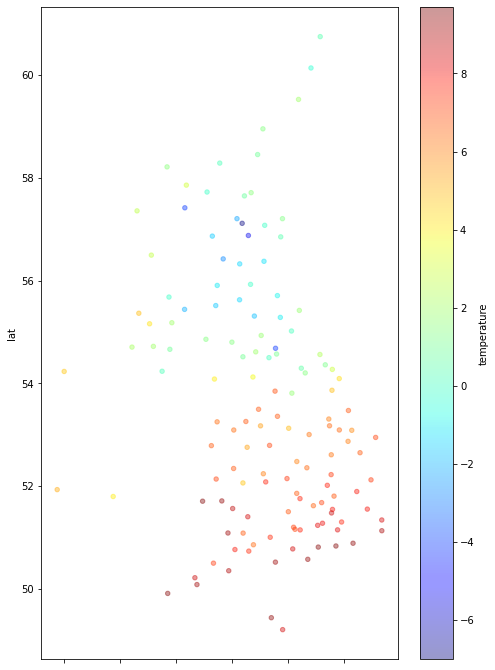

In [38]:
df.plot(
    kind="scatter",
    x="lon", y="lat",
    figsize=(8,12),
    cmap=plt.get_cmap("jet"),
    c='temperature',
    colorbar=True, alpha=0.4
)

# Raw Scatter Plot with OSGB Coords

How to convert coords to OSGB Eastings and Northings

In [39]:
from OSGridConverter import latlong2grid

def convert(r):
    g=latlong2grid(r['lat'], r['lon'])
    r['osgb_E'] = g.E
    r['osgb_N'] = g.N
    return r

osgb = df.apply(convert, axis=1)

osgb

,site_id,site_name,lat,lon,temperature,osgb_E,osgb_N
0,3002,BALTASOUND,60.7490,-0.8540,0.4,462571,1207872
1,3068,LOSSIEMOUTH,57.7120,-3.3220,1.5,321331,869902
2,3214,WALNEY ISLAND,54.1250,-3.2570,3.7,317948,470635
3,3230,REDESDALE CAMP,55.2850,-2.2790,-1.0,382377,599021
4,3281,FYLINGDALES,54.3620,-0.6730,1.2,486325,497086
...,...,...,...,...,...,...,...
133,3507,SENNYBRIDGE,52.0630,-3.6140,4.8,289450,241743
134,3520,SHOBDON SAWS,52.2420,-2.8850,6.1,339668,260793
135,3544,CHURCH LAWFORD,52.3580,-1.3300,6.5,445726,273538
136,3680,ROTHAMSTED,51.8067,-0.3602,6.8,513153,213278


# geopandas

*geopandas* creates some nice static figures, perfect for using in docs and articles.  You can use vector data from shape files, as per the first example below (which looks a bit 1980's because of the very low res shape data) or you can use a `geotiff` image as a background as per the second example.

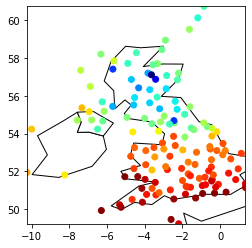

In [40]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))

# Could load a different shape file here!
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'Europe'].plot(color='white', edgecolor='black')

bounds = gdf.geometry.total_bounds
xlim = ([bounds[0],  bounds[2]])
ylim = ([bounds[1],  bounds[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Note that the colour fields to use here are 'column' and 'cmap' rather than 'c' and 'cmap' as in the scatter plots above!
gdf.plot(ax=ax, cmap=plt.get_cmap("jet"), column='temperature')

plt.show()

<AxesSubplot:title={'center':'UK Weather Stations by Minimum Temperature'}>

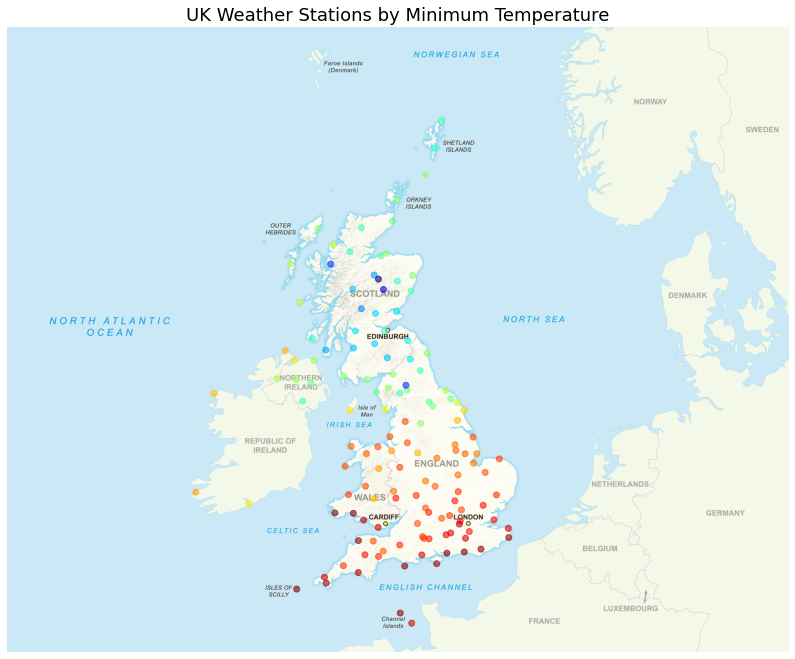

In [41]:
import rasterio.plot

# Note that the geotiff image we're using is in OSGB coords, so we need to use the same coordinate system for the points
gdf_osgb = geopandas.GeoDataFrame(osgb, geometry=geopandas.points_from_xy(osgb.osgb_E, osgb.osgb_N))

raster_data = rasterio.open('data/GBOverview.tif', masked=True)
extent=[raster_data.bounds[0], raster_data.bounds[2], raster_data.bounds[1], raster_data.bounds[3]]

f, ax = plt.subplots(figsize=(14, 14))
ax.set_title('UK Weather Stations by Minimum Temperature', fontdict={'fontsize': '18', 'fontweight' : '3'})
ax.set_axis_off()

rasterio.plot.show(raster_data, ax=ax, extent=extent)
gdf_osgb.plot(ax=ax, cmap=plt.get_cmap("jet"), column='temperature', alpha=0.6)


# Folium

Another python library that wraps Leaflet.  Unlike ipyleaflet, it works in PyCharm's notebook editor.  However, because the output is a big chunk of interactive JS, you don't see the output on platforms like github - so what you gain in interactivity, you lose in shareability.

In [42]:
import folium
from branca.element import Figure

fig=Figure(width=600,height=800)

mid_lat = df['lat'].mean()
mid_lon = df['lon'].mean()

m = folium.Map(location=[mid_lat, mid_lon], tiles = 'Stamen Terrain', zoom_start=6)

df['marker_color'] = pd.cut(df['temperature'], bins=4, labels=['#5599DD', '#55DD55', '#FFAA66', '#DD6666'])

for index, row in df.iterrows():
    folium.CircleMarker(location=(row['lat'], row['lon']), radius=4, weight=2, color=row['marker_color'], fill_color=row['marker_color'], fill_opacity=0.7).add_to(m)

fig.add_child(m)
m

# A better shape file for the UK...

http://www.diva-gis.org/datadown

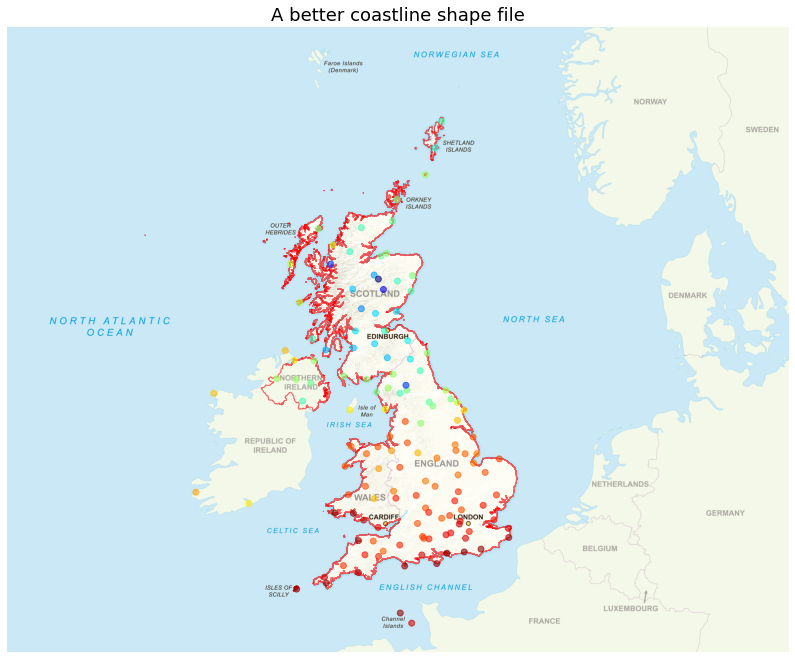

In [43]:
raster_data = rasterio.open('data/GBOverview.tif', masked=True)
extent=[raster_data.bounds[0], raster_data.bounds[2], raster_data.bounds[1], raster_data.bounds[3]]

f, ax = plt.subplots(figsize=(14, 14))
ax.set_title('A better coastline shape file', fontdict={'fontsize': '18', 'fontweight' : '3'})
ax.set_axis_off()

rasterio.plot.show(raster_data, ax=ax, extent=extent)

uk = geopandas.read_file('data/GBR_adm0/GBR_adm0.shp')
# Convert the shape data to OSGB coords - could equally do this the other way round and use lat long WGS84 everywhere if preferred/needed.
uk = uk.to_crs(epsg=27700)

uk.plot(ax=ax, facecolor='none', edgecolor='red', alpha=.6)
gdf_osgb.plot(ax=ax, cmap=plt.get_cmap("jet"), column='temperature', alpha=0.6)

plt.show()

# Filter points using a shapefile

This can be done using an inner join. The CRS of each dataset needs to be explicitly set, and obviously needs to match.  The join will link the points to the shape from the shape file which contains them. In our case, weather stations in the channel islands etc will be filtered out, as they are outside the coastline.

There might be some interesting use-cases for using a `left` rather than `inner` join and multiple shape files - allowing you to put each weather station into a UK county (for example).

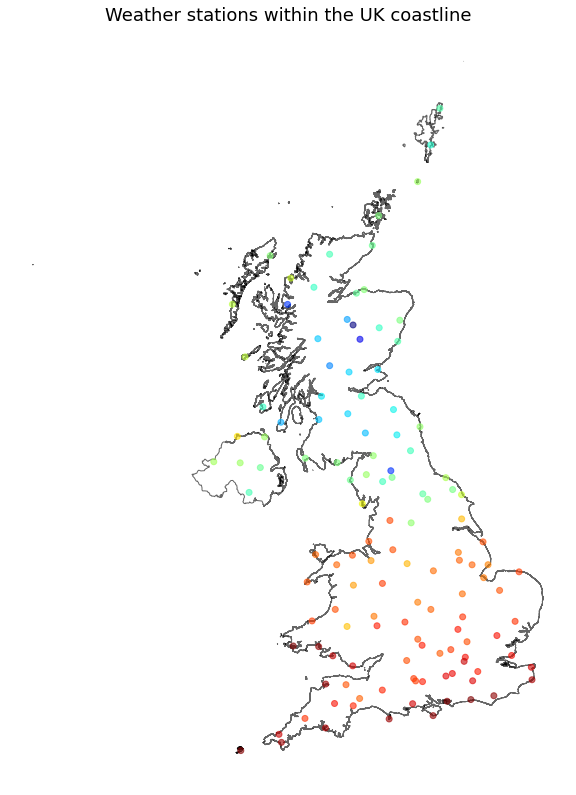

,site_id,site_name,lat,lon,temperature,osgb_E,osgb_N,geometry,index_right,ID_0,...,CSN,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC
0,3002,BALTASOUND,60.749,-0.854,0.4,462571,1207872,POINT (462571.000 1207872.000),0,242,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3068,LOSSIEMOUTH,57.712,-3.322,1.5,321331,869902,POINT (321331.000 869902.000),0,242,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3214,WALNEY ISLAND,54.125,-3.257,3.7,317948,470635,POINT (317948.000 470635.000),0,242,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3230,REDESDALE CAMP,55.285,-2.279,-1.0,382377,599021,POINT (382377.000 599021.000),0,242,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3281,FYLINGDALES,54.362,-0.673,1.2,486325,497086,POINT (486325.000 497086.000),0,242,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
from geopandas.tools import sjoin

f, ax = plt.subplots(figsize=(14, 14))
ax.set_title('Weather stations within the UK coastline', fontdict={'fontsize': '18', 'fontweight' : '3'})
ax.set_axis_off()

uk = geopandas.read_file('data/GBR_adm0/GBR_adm0.shp')
uk = uk.to_crs(epsg=27700)
# Need to explicitly set the CRS of the weather station data for the join to work
gdf_osgb.crs = "EPSG:27700"

points_inside_boundary = sjoin(gdf_osgb, uk, how='inner')

uk.plot(ax=ax, facecolor='white', edgecolor='black', alpha=.6)
points_inside_boundary.plot(ax=ax, cmap=plt.get_cmap("jet"), column='temperature', alpha=0.6)

plt.show()
points_inside_boundary.head()

# A Voronoi Diagram
https://wellsr.com/python/python-voronoi-diagram-with-geopandas-and-geoplot/

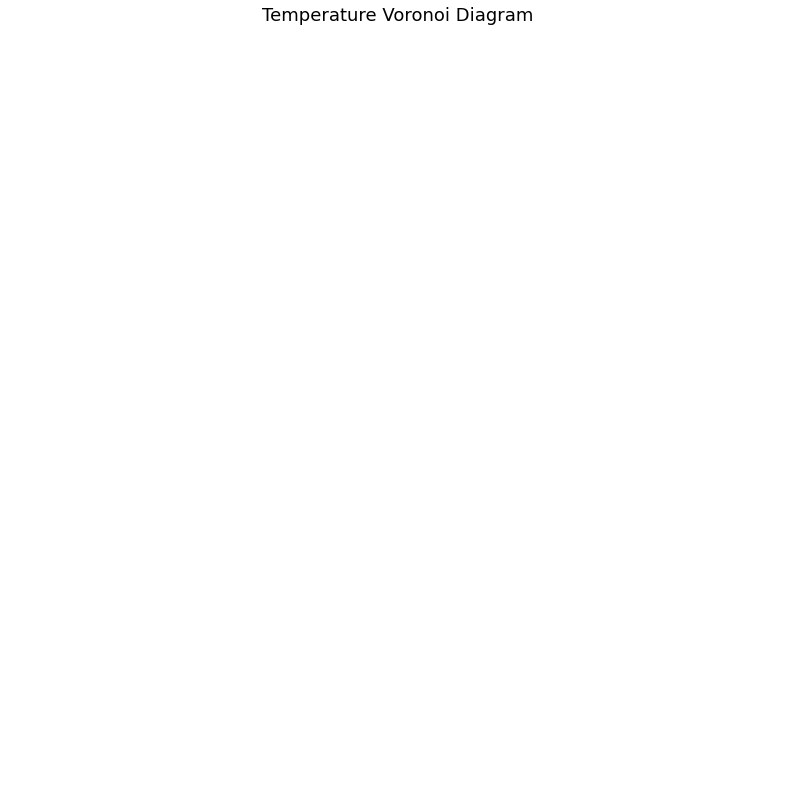

In [45]:
import geoplot
from shapely.geometry import box, Polygon

f, ax = plt.subplots(figsize=(14, 14))
ax.set_title('Temperature Voronoi Diagram', fontdict={'fontsize': '18', 'fontweight' : '3'})
ax.set_axis_off()

uk = geopandas.read_file('data/GBR_adm0/GBR_adm0.shp')
islands_of_uk = uk.explode(index_parts=True).to_crs(epsg=3857)
gdf.crs = "EPSG:3857"
islands_and_weather_stations = sjoin(islands_of_uk, gdf, how='inner')[["site_name", "geometry"]]
mainland = islands_and_weather_stations.where(islands_and_weather_stations['site_name'] == 'EXETER AIRPORT')

points = points_inside_boundary[['geometry', 'site_name', 'temperature']].dropna()

#proj = geoplot.crs.WebMercator()
#ax = geoplot.voronoi(points, hue='temperature', projection=proj, clip=mainland, cmap=plt.get_cmap("jet"), legend=True, edgecolor='white', linewidth=0.01)

# Voronoi Magic!
#ax = geoplot.voronoi(points_inside_boundary, hue='temperature', clip=uk, cmap=plt.get_cmap("jet"), legend=True, edgecolor='white', linewidth=0.01)
#islands_and_weather_stations.plot(ax=ax, facecolor='white', edgecolor='black', alpha=.6)

#plt.show()